### Metaparameter & dataset description
Load meta structure before using any subsequent code. Its required for most of functions and operations.

In [83]:
%reset -f

#--- path to graph vector data
path = 'data/graph/'

#--- metadata
meta = dict()
meta['atl'] = ['pow','har','dos','aal','mul'] 
meta['mod'] = ['cor','par']
meta['thr'] = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]
meta['N_ses'] = 4   # number of sessions per subject
meta['N_gvm'] = 10  # number of graph measures 

### (C) Evaluation using training and test sets

#### (C1) Create training and test sets
Looking for GV files within `path` location and dividing it into two equally sized groups preserving files for same subjects but different sessions within one group. 

In [84]:
from os.path import join, exists
from os import listdir
from random import shuffle
from shutil import copy2

#--- create path names
datapath = join(path,'..')
path_train = join(datapath, 'graph_train/')
path_test = join(datapath, 'graph_test/')

#--- get subjects
gv_files = listdir(path)
gv_files = [file for file in gv_files if file.find('GV.txt') != -1] 
subs = list(set([file[11:13] for file in gv_files])); shuffle(subs)

if not exists(path_train):
    #--- divide subjects into two groups
    N_split = int(len(subs) / 2)    
    subs_train = subs[:N_split]
    subs_test = subs[N_split:]
    subs_train_files = [f for f in listdir(path) if f[11:13] in subs_train]
    subs_test_files = [f for f in listdir(path) if f[11:13] in subs_test]

#--- create folders (done only if folders doesn't exist!)
if not exists(path_train):
    !mkdir $path_train
    for file in subs_train_files:
        oldfile = join(path, file)
        copy2(oldfile, path_train)
if not exists(path_test):
    !mkdir $path_test
    for file in subs_test_files:
        oldfile = join(path, file)
        copy2(oldfile, path_test)

#### (C2) Finding optimal beta vector for training set


In [85]:
from identipy import beta_lin_comb, load_data, quality_function
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import random
import time

meta['N_sub'] = len(subs_train)

#--- load data
print('Loading the data...')
GVDAT_train, sub_list_train = load_data(path_train, meta)
print('Data succesfully loaded.\n')

#--- function to minimize
def quality_simple_fast(beta):
    beta = list(beta)
    gv_array = beta_lin_comb(beta, GVDAT_train, meta)
    return quality_function(sub_list_train, gv_array, similarity='euclid')

#--- initiate metaparameter vector
N_met = len(meta['atl']) + len(meta['mod']) + len(meta['thr']) 
b0 = np.asarray([random.uniform(0,1) for idx in range(N_met)])

#--- define constrains
bounds = Bounds([0 for idx in range (N_met)],[1 for idx in range (N_met)])
    
#--- minimize
print('Beginning optimization...')
res = minimize(quality_simple_fast, b0, method='SLSQP', options={'disp': True}, bounds=bounds)

Loading the data...
Data succesfully loaded.

Beginning optimization...
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6988514747859383
            Iterations: 92
            Function evaluations: 1665
            Gradient evaluations: 92


#### (C3) Evaluating beta vector on a test set

In [86]:
from identipy import beta_lin_comb, load_data, quality_function
import numpy as np

meta['N_sub'] = len(subs_test)

#--- load data
print('Loading the data...')
GVDAT_test, sub_list_test = load_data(path_test, meta)
print('Data succesfully loaded.\n')

#--- quality function for test set
q_test = quality_function(sub_list_test, beta_lin_comb(list(res.x), GVDAT_test, meta), similarity='euclid')
print(f'Quality function for test set: {q_test}')

N_thr = len(meta['thr'])
N_atl = len(meta['atl'])
q = {}
for mod in meta['mod']:
    #--- store results in array for each model separately
    q[mod] = np.zeros([N_atl, N_thr])
    for tup in [(atl, thr) for atl in range(N_atl) for thr in range(N_thr)]:
        # print(' Model: {}, Atlas: {}, Threshold: {}'.format(mod, meta['atl'][tup[0]], str(tup[1])))
        #--- create beta corresponding to 'simple measurement'
        beta = [ int(x == tup[0]) for x in range(N_atl)] + \
               [ int(mod in model) for model in meta['mod'] ] + \
               [ int(x == tup[1]) for x in range(N_thr)]
        #--- calculate identifiability
        q[mod][tup[0]][tup[1]] = quality_function(sub_list_test, beta_lin_comb(beta, GVDAT_test, meta), similarity='euclid')

Loading the data...
Data succesfully loaded.

Quality function for test set: 0.9139918623528955


#### (C4) Plotting...

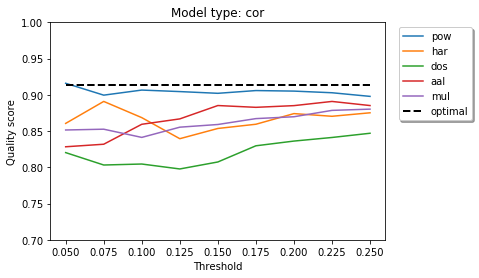

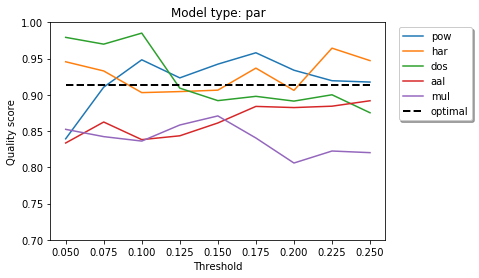

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for mod in meta['mod']:
    #--- 
    plt.plot(np.linspace(0.05,0.25,9),q[mod].T)
    if 'res' in globals():
        plt.plot(np.linspace(0.05,0.25,9), [q_test for idx in range(9)], 'k--', linewidth=2)
    plt.xticks(np.linspace(0.05,0.25,9))
    plt.ylim((0.70,1))
    #--- cosmetic changes
    plt.title('Model type: {}'.format(mod))
    plt.xlabel('Threshold')
    plt.ylabel('Quality score')
    if 'res' in globals():
        meta_atl_leg = meta['atl'].copy() 
        meta_atl_leg.append('optimal')
        plt.legend(meta_atl_leg, loc='upper center', bbox_to_anchor=(1.15, 1),
                  fancybox=True, shadow=True)
    else:
        plt.legend(meta['atl'], loc='upper center', bbox_to_anchor=(1.1, 1),
                  fancybox=True, shadow=True)
    plt.show()

Function minimum value: Q = 0.6989


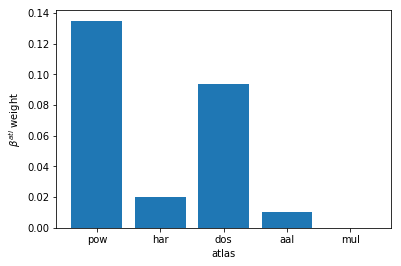

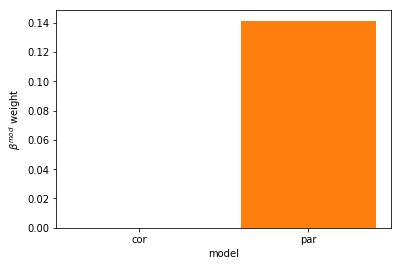

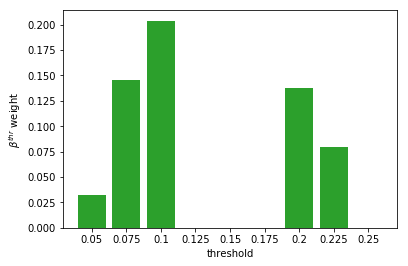

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

#--- get optimal beta vector
b_opt = res.x / np.sum(res.x) # normalize
print(f'Function minimum value: Q = {round(res.fun, 4)}')

plt.bar(meta['atl'], b_opt[:N_atl], color='C0')
plt.ylabel(r'$\beta^{atl}$ weight')
plt.xlabel('atlas')
plt.show()

plt.bar(meta['mod'], b_opt[N_atl:-N_thr], color='C1')
plt.ylabel(r'$\beta^{mod}$ weight')
plt.xlabel('model')
plt.show()

plt.bar([str(thr) for thr in meta['thr']], b_opt[-N_thr:], color='C2')
plt.ylabel(r'$\beta^{thr}$ weight')
plt.xlabel('threshold')
plt.show()